In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Column, join, vstack, setdiff

from astropy.visualization import make_lupton_rgb
from astropy.visualization import LogStretch, SqrtStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm1, norm2, norm3 = [ImageNormalize(stretch=LogStretch()) for i in range(3)]
norm0 = ImageNormalize(stretch=AsinhStretch(a=0.01))

### Make RGB from SDSS u,g,i

In [7]:
header = fits.getheader('./mosaic/J215334.00+174010.0-g.fits')
wcs = WCS(header)

# img_u = fits.getdata('./mosaic/J215334.00+174010.0-u.fits')
img_g = fits.getdata('./mosaic/J215334.00+174010.0-g.fits')
img_r = fits.getdata('./mosaic/J215334.00+174010.0-r.fits')
img_i = fits.getdata('./mosaic/J215334.00+174010.0-i.fits')

In [14]:
rgb = make_lupton_rgb(img_i, img_r, img_g, Q=0.1, stretch=0.8, filename="Abell2390_ugz.jpeg")

In [99]:
hdu_rgb = fits.PrimaryHDU(data=rgb, header=header)
hdu_rgb.writeto('./mosaic/A2390_RGB.fits', overwrite=True)

### Read Made RGB

In [4]:
rgb = fits.getdata('./mosaic/A2390_RGB.fits')
header = fits.getheader('./mosaic/J215334.00+174010.0-g.fits')
wcs = WCS(header)

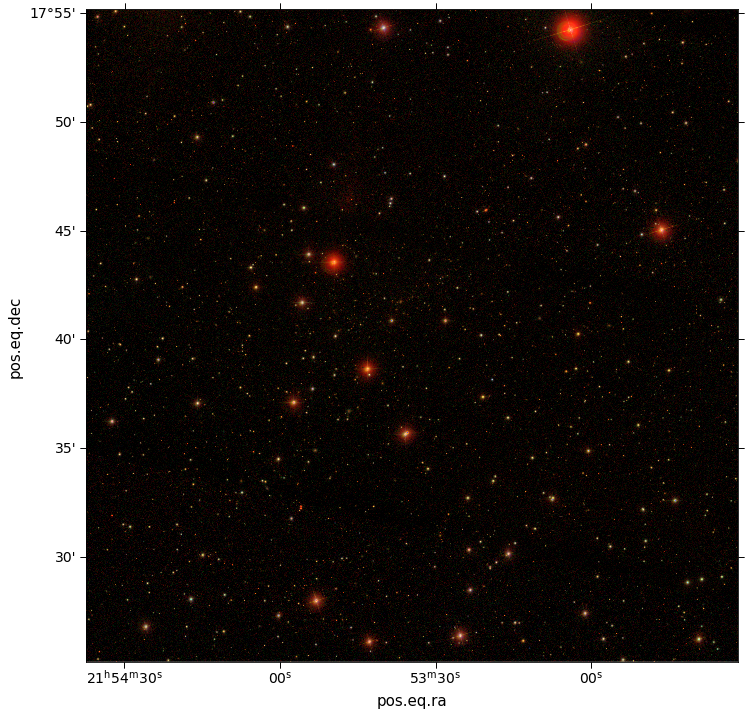

In [17]:
plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection=wcs)
ax.imshow(rgb)

### Read field

In [5]:
from pipeline import *
from utils import *

datacube_C = Read_Datacube('./proc/A2390C/A2390C_cube.fits', 
                             name='A2390C', z0=0.228, mode="MMA",
                             table='./proc/A2390C/A2390C_MMA_lpf.dat', 
                             deep_frame='./proc/A2390C/A2390C_DF.fits',
                             mask_edge='./proc/A2390C/Raw_stack_A2390C_mask.fits')
datacube_C.get_wcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 328.394  17.6697222222  
CRPIX : 1079.25968262  1033.22775456  
CD1_1 CD1_2  : -9.00274955272e-05  -8.61822428328e-07  
CD2_1 CD2_2  : -8.61822428328e-07  9.00274955272e-05  
NAXIS : 2048  2064  57

In [6]:
datacube_E = Read_Datacube('./output/A2390E/A2390E_cube.fits',
                           name='A2390E', z0=0.228, mode="MMA",
                           table='./output/A2390E/A2390E_MMA_lpf.dat',
                           deep_frame='./output/A2390E/A2390E_DF.fits',
                           mask_edge='./output/A2390E/Raw_stack_A2390E_mask.fits')
datacube_E.get_wcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 328.497083333  17.5375  
CRPIX : 1077.08705104  1033.22775456  
PC1_1 PC1_2  : -8.98848160834e-05  -9.30612045935e-07  
PC2_1 PC2_2  : -9.30612045935e-07  8.98848160834e-05  
CDELT : 1.0  1.0  
NAXIS : 2048  2064  69

In [7]:
datacube_W = Read_Datacube('./output/A2390W/A2390W_cube.fits',
                           name='A2390W', z0=0.228, mode="MMA",
                           table='./output/A2390W/A2390W_MMA_lpf.dat',
                           deep_frame='./output/A2390W/A2390W_DF.fits',
                           mask_edge='./output/A2390W/Raw_stack_A2390W_mask.fits')
datacube_W.get_wcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 328.279166667  17.8233333333  
CRPIX : 1074.91441947  1033.22775456  
PC1_1 PC1_2  : -8.99554971216e-05  -9.60698956172e-07  
PC2_1 PC2_2  : -9.60698956172e-07  8.99554971216e-05  
CDELT : 1.0  1.0  
NAXIS : 2048  2064  69

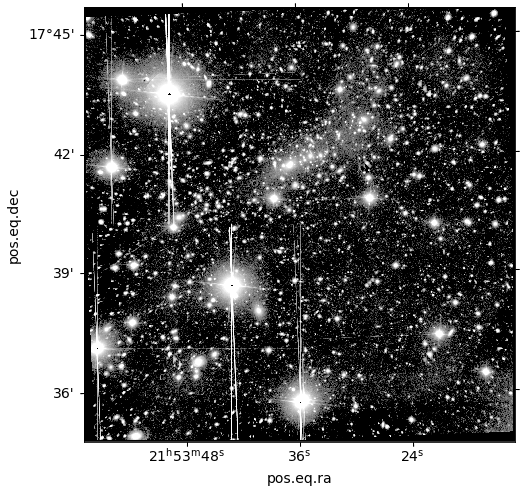

In [26]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection=datacube_C.wcs)
ax.imshow(datacube_C.deep_frame, norm=norm0,
          cmap='gray', vmin=np.median(datacube_C.deep_frame), vmax=100)

### Reproject Deep Frame on RGB mosaic

In [82]:
from reproject import reproject_interp
array_C, footprint_C = reproject_interp((datacube_C.deep_frame, datacube_C.wcs), header)
array_W, footprint_W = reproject_interp((datacube_W.deep_frame, datacube_W.wcs), header)
array_E, footprint_E = reproject_interp((datacube_E.deep_frame, datacube_E.wcs), header)

/home/qliu/anaconda3/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


In [83]:
for arr, name in zip([array_C, array_E, array_W],['A2390C','A2390E','A2390W']):
    hdu_rep = fits.PrimaryHDU(data=arr, header=header)
    hdu_rep.writeto('./mosaic/%s_reproj.fits'%name, overwrite=True)

### Read Reprojected Deep Frame

In [8]:
array_C = fits.getdata('./mosaic/A2390C_reproj.fits')
array_E = fits.getdata('./mosaic/A2390E_reproj.fits')
array_W = fits.getdata('./mosaic/A2390W_reproj.fits')

In [9]:
def make_log_cutout(array):
    array2 = np.nan_to_num(array)
    log_stretch = np.where(array2>max(np.nanmedian(array),0))
    array2[log_stretch] = np.log10(array2[log_stretch])
    array2 = np.ma.masked_where(np.isnan(array), array2)
    return array2

field_C = make_log_cutout(array_C)
field_E = make_log_cutout(array_E)
field_W = make_log_cutout(array_W)

In [10]:
coords = np.vstack([[coord.ra.value, coord.dec.value]
                    for coord in [SkyCoord(dc.header["TARGETR"], dc.header["TARGETD"], unit=(u.hourangle,u.deg))
                                           for dc in [datacube_C, datacube_E, datacube_W]]])
cen_field = wcs.all_world2pix(coords, 0)

In [53]:
tab_A2390C = Table.read('./output/A2390C/centroid_analysis_A2390C_mean_sn2.0_contsub_lpf_NB.txt', format='ascii')
tab_A2390E = Table.read('./output/A2390E/centroid_analysis_A2390E_mean_sn2.0_contsub_lpf_NB.txt', format='ascii')
tab_A2390W = Table.read('./output/A2390W/centroid_analysis_A2390W_mean_sn2.0_contsub_lpf_NB.txt', format='ascii')

set_radius(tab_A2390C, datacube_C)
set_radius(tab_A2390E, datacube_E)
set_radius(tab_A2390W, datacube_W)

c_A2390C, c_A2390E, c_A2390W = [SkyCoord(tab['ra'], tab['dec'], frame='icrs', unit="deg")
                                for tab in [tab_A2390C, tab_A2390E, tab_A2390W]]

idx, d2d, d3d = c_A2390E.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_EC = tab_A2390E[match]
tab_CE = tab_A2390C[idx[match]]

idx, d2d, d3d = c_A2390W.match_to_catalog_sky(c_A2390C)
match = d2d < 3*u.arcsec
tab_WC = tab_A2390W[match]
tab_CW = tab_A2390C[idx[match]]

tab_E, tab_C, tab_W = tab_A2390E.copy(), tab_A2390C.copy(), tab_A2390W.copy()
tab_A2390 = vstack([tab_C, tab_E , tab_W], join_type='inner')

# Remove repeated source with lower SNR
good_E = tab_EC['SN_Ha']>tab_CE['SN_Ha']
id_rm_EC = tab_EC['ID'][~good_E].data
id_rm_CE = tab_CE['ID'][good_E].data

good_W = tab_WC['SN_Ha']>tab_CW['SN_Ha']
id_rm_WC = tab_WC['ID'][~good_W].data
id_rm_CW = tab_CW['ID'][good_W].data

for id_rm in np.concatenate([id_rm_EC, id_rm_WC, id_rm_CW, id_rm_CE]):
    tab_A2390.remove_row(np.where(tab_A2390['ID']==id_rm)[0][0])
    
id_BCG = tab_A2390[np.argmin((tab_A2390["ra"]-328.4035120)**2 + (tab_A2390["dec"]-17.6954401)**2)]['ID']
tab_A2390[:10]

ID,ra,dec,z,X,Y,SN_Ha,SN_OIII,SN_OII,diff_angle_ISO-D,cen_offset_ISO-D,diff_angle_std_ISO-D,cen_offset_std_ISO-D,pa_ISO-D,diff_angle_ISO-Dm,cen_offset_ISO-Dm,diff_angle_std_ISO-Dm,cen_offset_std_ISO-Dm,pa_ISO-Dm,clus_cen_angle,dist_clus_cen,radius
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1C,328.4375,17.5798,0.2502,621.75,15.079999999999998,30.463,29.127,33.247,79.765,1.281,12.539,0.232,264.578,76.076,1.775,4.844,0.15,268.267,344.343,1342.154,5.81
6C,328.3969,17.5803,0.2472,1056.61,27.87,9.298,10.252,9.412,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.88
89C,328.3088,17.5895,0.2475,2005.26,130.44,5.684,6.27,6.182,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.26
96C,328.3757,17.5897,0.226,1281.49,138.51,5.591,5.059,6.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.52
106C,328.4743,17.5928,0.2322,223.86,153.6,6.459,6.056,6.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.81
119C,328.4807,17.5953,0.2357,154.26,180.01,4.898,5.27,5.568,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.81
124C,328.4377,17.5953,0.2424,620.0,193.88,8.025,8.813,8.104,160.437,2.877,1.568,0.054,181.523,143.925,1.833,8.414,0.269,198.034,341.96,1176.967,5.81
197C,328.3146,17.6045,0.2442,1935.64,306.22,4.429,5.2,4.874,147.301,2.989,10.247,0.464,255.684,147.135,2.762,6.57,0.317,255.85,42.985,1389.415,5.81
212C,328.3937,17.607,0.25,1087.34,333.52,49.554,18.655,19.659,58.888,0.416,1.526,0.011,307.116,19.222,0.472,14.258,0.118,346.782,6.004,994.691,7.96


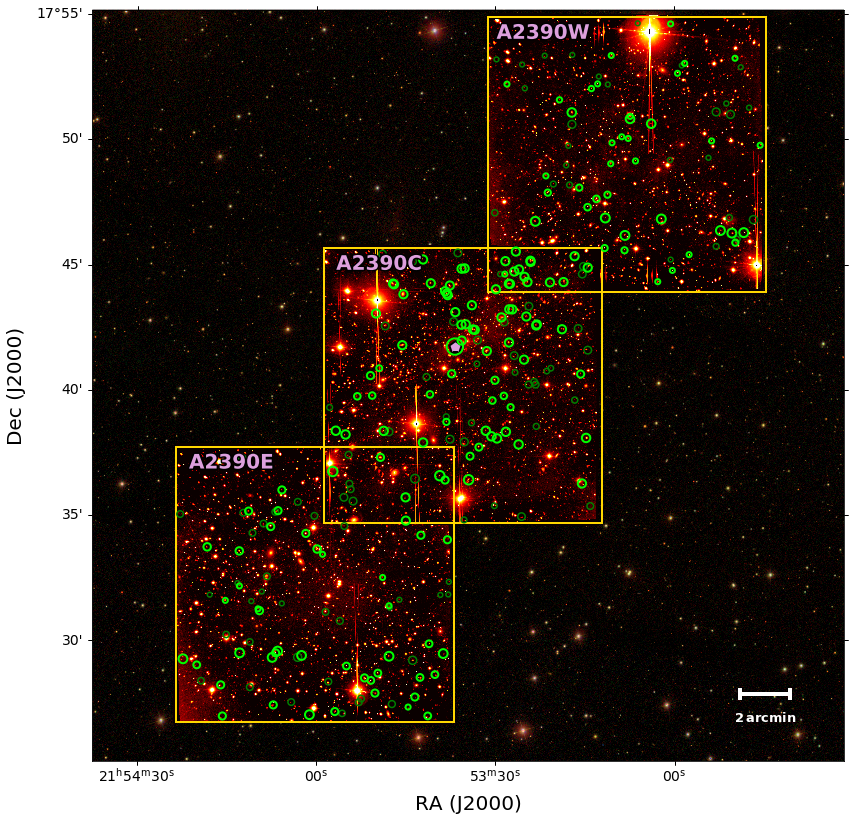

In [56]:
fig = plt.figure(figsize=(13,12))
ax = plt.subplot(111, projection=wcs)
ax.imshow(rgb, vmin=0, norm=norm0)
ax.imshow(array_E, cmap='hot', norm=AsinhNorm(a=0.01), vmin=-1, vmax=1e3, alpha=1)
ax.imshow(array_W, cmap='hot', norm=AsinhNorm(a=0.01), vmin=-1, vmax=1e3, alpha=1)
ax.imshow(array_C, cmap='hot', norm=AsinhNorm(a=0.01), vmin=-1, vmax=1e3, alpha=1)

for cen, field in zip(cen_field, ['C','E','W']):
    rec = Rectangle((cen[0]-1072, cen[1]-1024), 2064, 2048,
                    linewidth=2, edgecolor='gold', facecolor='none')
    ax.add_patch(rec)
    ax.text(cen[0]-660, cen[1]+900, r"$\bf A2390%s$"%field,
            path_effects=[PathEffects.withStroke(linewidth=3, foreground="k")],
            color='plum', va='center', ha='center', fontsize=20, zorder=4)
    
for i, (obj) in enumerate(tab_A2390):
    if obj['cen_offset_ISO-D']>0:
        if obj['ID'] ==id_BCG:
            plt.scatter(obj['ra'], obj['dec'], s=20+25*obj['radius'], linewidth=2, marker='p',
                    transform=ax.get_transform('fk5'), facecolor="plum", edgecolor="k", zorder=1)
            plt.scatter(obj['ra'], obj['dec'], s=35+40*obj['radius'],
                    transform=ax.get_transform('fk5'), linewidth=2, facecolor="none", edgecolor="lime",zorder=3)
        else:
            plt.scatter(obj['ra'], obj['dec'], s=10+10*obj['radius'],
                        transform=ax.get_transform('fk5'), linewidth=2, facecolor="none", edgecolor="lime",zorder=3)
    else:
        plt.scatter(obj['ra'], obj['dec'], s=10+8*obj['radius'],
                    transform=ax.get_transform('fk5'), linewidth=1.5, facecolor="none", edgecolor="g",zorder=2)
    
L_pix = 120/0.322
ax.plot([5000-L_pix/2,5000+L_pix/2],[500,500], 'w', lw=4)
ax.plot([5000-L_pix/2,5000-L_pix/2],[470,530], 'w', lw=4)
ax.plot([5000+L_pix/2,5000+L_pix/2],[470,530], 'w', lw=4)
ax.text(5000, 320, r"$\bf 2\,arcmin$", color='w', va='center', ha='center', fontsize=13)

ax.set_xlabel('RA (J2000)',fontsize=20)
ax.set_ylabel('Dec (J2000)',fontsize=20)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.08, top=0.95)
plt.savefig('./pic/A2390_Field_ELG.pdf')

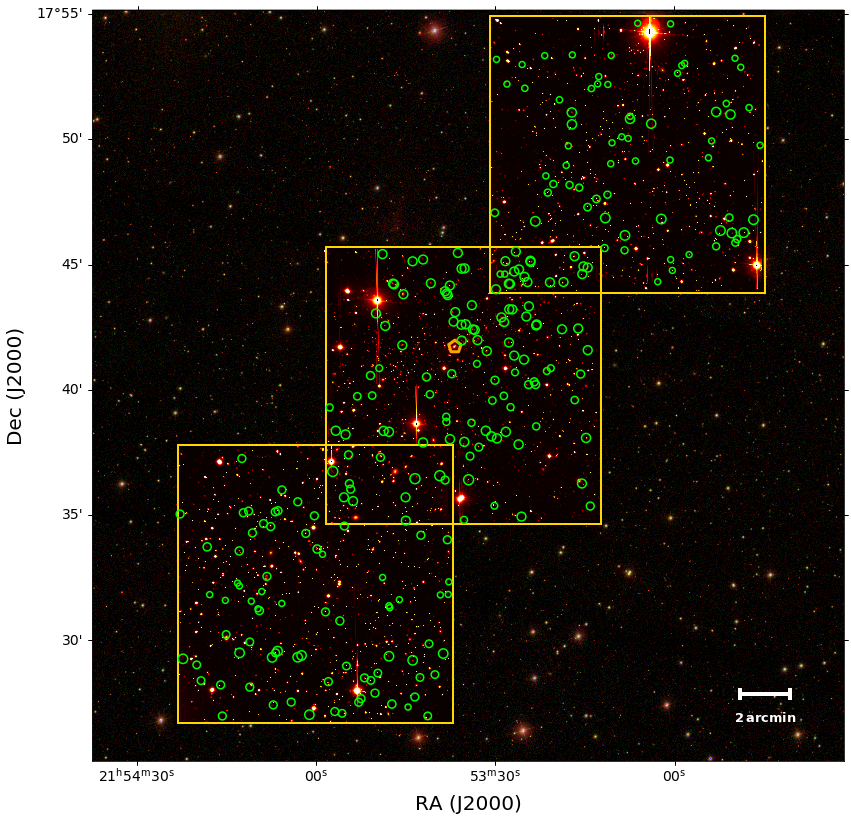

In [62]:
# tab_A2390['X_field'], tab_A2390['Y_field'] = wcs.all_world2pix(tab_A2390['ra'], tab_A2390['dec'], 0)

# fig = plt.figure(figsize=(13,12))
# ax = plt.subplot(111, projection=wcs)
# ax.imshow(rgb, vmin=0, norm=norm0)
# ax.imshow(array_C, cmap='hot', norm=AsinhNorm(a=0.1), vmin=0, vmax=1e3, alpha=0.98)
# ax.imshow(array_E, cmap='hot', norm=AsinhNorm(a=0.1), vmin=0, vmax=1e3, alpha=0.98)
# ax.imshow(array_W, cmap='hot', norm=AsinhNorm(a=0.1), vmin=0, vmax=1e3, alpha=0.98)

# for cen in cen_field:
#     rec = Rectangle((cen[0]-1060, cen[1]-1032), 2048, 2064,
#                     linewidth=2, edgecolor='gold', facecolor='none')
#     ax.add_patch(rec)
    
# for i, (obj) in enumerate(tab_A2390):
#     if obj['cen_offset_ISO-D']>0:
#         if obj['ID'] ==id_BCG:
#             plt.scatter(obj['X_field'], obj['Y_field'], s=20+25*obj['radius'], linewidth=3, marker='p',
#                     facecolor="plum", edgecolor="k", zorder=1)
        
#         plt.scatter(obj['X_field'], obj['Y_field'], s=20+10*obj['radius'],
#                     linewidth=1.5, facecolor="none", edgecolor="lime",zorder=3)
#     else:
#         plt.scatter(obj['X_field'], obj['Y_field'], s=20+10*obj['radius'],
#                     linewidth=1.5, facecolor="none", edgecolor="g",zorder=2)
    
# L_pix = 120/0.322
# ax.plot([5000-L_pix/2,5000+L_pix/2],[500,500], 'w', lw=4)
# ax.plot([5000-L_pix/2,5000-L_pix/2],[470,530], 'w', lw=4)
# ax.plot([5000+L_pix/2,5000+L_pix/2],[470,530], 'w', lw=4)
# ax.text(5000, 320, r"$\bf 2\,arcmin$", color='w', va='center', ha='center', fontsize=13)

# ax.set_xlabel('RA (J2000)',fontsize=20)
# ax.set_ylabel('Dec (J2000)',fontsize=20)
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.08, top=0.95)
# plt.savefig('./pic/A2390_Field_ELG_corr.pdf')